# Задача Римана о распаде разрыва

$$\frac{\partial \bar U}{\partial t} + \frac{\partial \bar F(\bar U)}{\partial x} = 0$$

Надо использовать схему $HHL$ по пространству, схему Рунге-Кутты 1 порядка по времени. Так же здесь использована схема $ENO$ для улучшения апроксимации $U_L$ и $U_R$.

$$\frac{U_i^{n+1} - U_i^{n} }{\Delta t} + \frac{F_{i+\frac{1}{2}} - F_{i-\frac{1}{2}} }{\Delta x} = 0$$


$F^{HLL}_{i+\frac{1}{2}} = \begin{cases}
  F_L = F(U_L), \quad 0 \leq S_R\\
  \frac{S_RF_L - S_LF_R  + S_L S_R(U_R - U_L)}{S_R - S_L}, \quad S_l \leq 0 \leq S_R\\
  F_R = F(U_R), \quad 0 \geq S_R
\end{cases}$

Будем апроксимировать $U_L$ и $U_R$ с помощью $ENO$ схемы 2 порядка.

$U_m^{R, L} = U_m \pm \frac{h}{2}\Delta_m$

$\Delta_m = \begin{cases}
  \Delta_{m-\frac{1}{2}}, \quad |\Delta_{m-\frac{1}{2}}| < |\Delta_{m+\frac{1}{2}}|\\
  \Delta_{m+\frac{1}{2}}, \quad |\Delta_{m-\frac{1}{2}}| > |\Delta_{m+\frac{1}{2}}|
\end{cases}$

$\Delta_{m-\frac{1}{2}} = \frac{U_m - U_{m-1}}{h}$

$\Delta_{m+\frac{1}{2}} = \frac{U_{m+1} - U_{m}}{h}$

Пределы областей, где идет распространение волн определяются с помощью максимальных скоростей распространения волн.

$S_L = min(u_L - c_L, u_R - c_R)$

$S_R = max(u_L + c_L, u_R + c_R)$

Где $c = \sqrt{\frac{\gamma p}{\rho}}$.

Постановка задачи в консервативных переменных.

$\begin{equation*}
\bar U = \left(
\begin{array}{c}
\rho\\
\rho u\\
e
\end{array}
\right)
\end{equation*}$

$\begin{equation*}
\bar F = \left(
\begin{array}{c}
\rho u\\
p + \rho u^2\\
(p + e) u
\end{array}
\right)
\end{equation*}$

$e = \rho \varepsilon + \rho \frac{u^2}{2}$

$\varepsilon = \frac{p}{\rho (\gamma - 1)}$

Классические переменные выражаются из консервативных следующим образом.

$\rho = U_1$

$u = \frac{U_2}{U_1}$

$p = (\gamma - 1) (U_3 - \frac{U_2^2}{2U_1})$

$\gamma = 1.4$

Граничные условия задачи ставятся следующим образом.

$\rho_L = 1.0$

$u_L = 0.75$

$p_L = 1.0$

$\rho_R = 0.125$

$u_R = 0.0$

$p_R = 0.1$

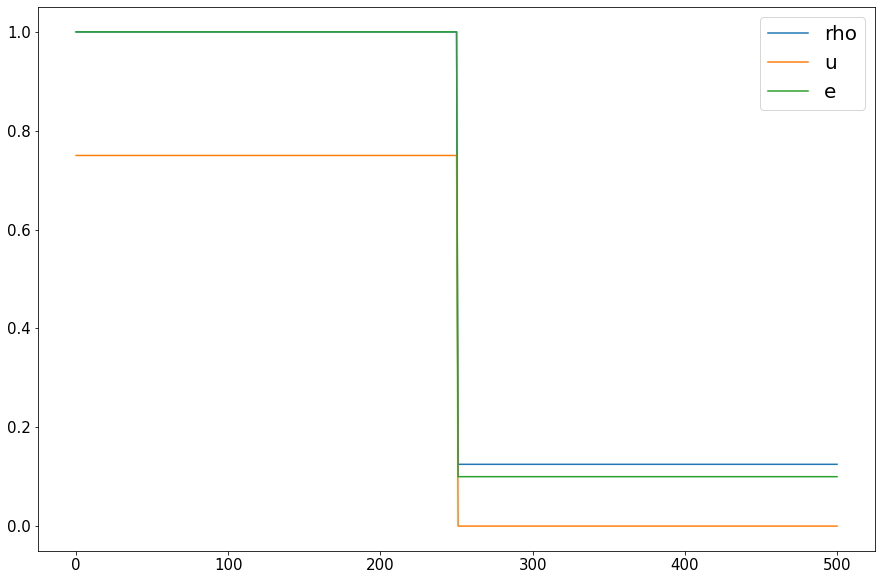

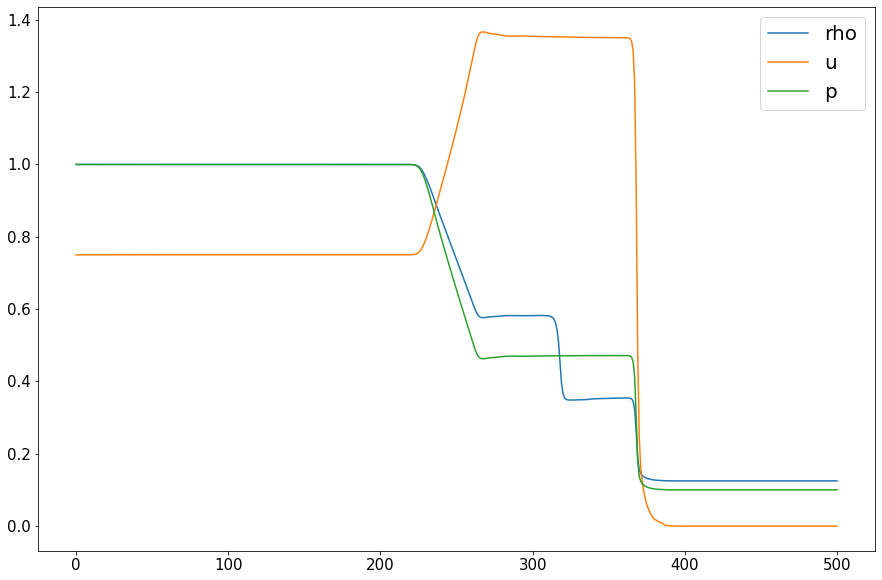

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

#Функция перехода в классические переменные задачи

def constonorm(Y):
  u = Y[1]/Y[0]
  rho = Y[0]
  e = Y[2]
  p = (gamma-1)*(e - rho*u**2/2)
  return np.array([rho, u, e])

#Функция F 

def func(gamma, Y):
  u = Y[1]/Y[0]
  rho = Y[0]
  e = Y[2]
  p = (gamma-1)*(e - rho*u**2/2)
  return np.array([rho*u, p + rho*u**2, (p+e)*u])

#Функция вычисления потока F по схеме HLL

def flux(gamma, YL, YR, SL, SR):
  if (SL >= 0):
    return func(gamma, YL)
  elif (SR <= 0):
    return func(gamma, YR)
  else:
    Fm = func(gamma, YL)
    Fm1 = func(gamma, YR)
    return (SR*Fm - SL*Fm1 + SL*SR*(YR-YL))/(SR-SL)

#Апроксимация UL и UR с помощью ENO схемы 2 порядка

def UL(Yl, Y, Yr):
      deltal = (Y-Yl)/h
      deltar = (Yr-Y)/h
      if (np.linalg.norm(deltal) < np.linalg.norm(deltar)):
        u = Y - h/2*deltal
      else:
        u = Y - h/2*deltar
      return(u)

def UR(Yl, Y, Yr):
      deltal = (Y-Yl)/h
      deltar = (Yr-Y)/h
      if (np.linalg.norm(deltal) < np.linalg.norm(deltar)):
        u = Y + h/2*deltal
      else:
        u = Y + h/2*deltar   
      return(u)

#Инициализация параметров и начальных условий задачи

a = 0
b = 1
N = 500
h = (b-a)/N
CFL = 0.3
T = 0.2
t = 0

rho = np.zeros(N+1)
u = np.zeros(N+1)
p = np.zeros(N+1)

gamma = 1.4

solL = np.zeros(3)
solR = np.zeros(3)

solL = np.array([1.0, 0.75, 1.0])
solR = np.array([0.125, 0.0, 0.1])

#Задание граничных условий в консервативных переменных

uL = np.zeros(3)
uR = np.zeros(3)

uL[0] = solL[0]
uL[1] = solL[0] * solL[1] 
uL[2] = solL[2] / (gamma - 1) + solL[0] * solL[1] * solL[1] / 2

uR[0] = solR[0]
uR[1] = solR[0] * solR[1] 
uR[2] = solR[2] / (gamma - 1) + solR[0] * solR[1] * solR[1] / 2

#Нахождение tau для первой итерации метода

pL = (gamma - 1)*(uL[2] - uL[1]**2/(2*uL[0]))
pR = (gamma - 1)*(uR[2] - uR[1]**2/(2*uR[0]))

if (gamma*pL / uL[0] <= 0):
  cL = 0
else:
  cL = math.sqrt(gamma*pL / uL[0])
if (gamma*pR / uR[0] <= 0):
  cR = 0
else:
  cR = math.sqrt(gamma*pR / uR[0])

maxS = max(uL[1]/uL[0] + cL, uR[1]/uR[0] + cR)

tau = CFL * h / maxS

#Инициализация решения, задание граничных условий, отрисовка начального состояния

Y = []

for i in range(N+1):
  if (i*h <= 0.5):
    Y.append(uL)
  if (i*h > 0.5):
    Y.append(uR)

for j in range(N+1):
    uu = Y[j][1]/Y[j][0]
    rhoo = Y[j][0]
    ee = Y[j][2]
    pp = (gamma-1)*(ee - rhoo*uu**2/2)
    rho[j] = rhoo
    u[j] = uu
    p[j] = pp

plt.figure(figsize = (15, 10))
plt.plot(range(N+1), rho, label='rho')
plt.plot(range(N+1), u, label='u')
plt.plot(range(N+1), p, label='e')
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#Решение задачи

while (t < T):
  for i in range(2, N-2):
    pL = (gamma - 1)*(Y[i-1][2] - Y[i-1][1]**2/(2*Y[i-1][0]))
    pc = (gamma - 1)*(Y[i][2] - Y[i][1]**2/(2*Y[i][0]))
    pR = (gamma - 1)*(Y[i+1][2] -Y[i+1][1]**2/(2*Y[i+1][0]))

    if (gamma*pL / Y[i-1][0] <= 0):
      cL = 0
    else:
      cL = math.sqrt(gamma*pL / Y[i-1][0])
    if (gamma*pc / Y[i][0] <= 0):
      c = 0
    else:
      c = math.sqrt(gamma*pc / Y[i][0])
    if (gamma*pR / Y[i+1][0] <= 0):
      cR = 0
    else:
      cR = math.sqrt(gamma*pR / Y[i+1][0])

    SLL = min(Y[i-1][1]/Y[i-1][0] - cL, Y[i][1]/Y[i][0] - c)
    SLR = max(Y[i-1][1]/Y[i-1][0] + cL, Y[i][1]/Y[i][0] + c)

    SRL = min(Y[i][1]/Y[i][0] - c, Y[i+1][1]/Y[i+1][0] - cR)
    SRR = max(Y[i][1]/Y[i][0] + c, Y[i+1][1]/Y[i+1][0] + cR)
    
    def UL(Yl, Y, Yr):
      deltal = (Y-Yl)/h
      deltar = (Yr-Y)/h
      if (np.linalg.norm(deltal) < np.linalg.norm(deltar)):
        u = Y - h/2*deltal
      else:
        u = Y - h/2*deltar
      return(u)

    def UR(Yl, Y, Yr):
      deltal = (Y-Yl)/h
      deltar = (Yr-Y)/h
      if (np.linalg.norm(deltal) < np.linalg.norm(deltar)):
        u = Y + h/2*deltal
      else:
        u = Y + h/2*deltar   
      return(u)

    FL = flux(gamma, UR(Y[i-2], Y[i-1], Y[i]), UL(Y[i-1], Y[i], Y[i+1]), SLL, SLR)
    FR = flux(gamma, UR(Y[i-1], Y[i], Y[i+1]), UL(Y[i], Y[i+1], Y[i+2]), SRL, SRR)

    Y[i] = Y[i] - tau/h * (FR - FL)  

    #Адаптивный выбор tau

    maxS = max(SLR, SRR)

    tau = CFL * h / maxS

  if (t + tau > T):
    tau = T - t

  t += tau

#Отрисовка конечного состояния

for j in range(N+1):
    uu = Y[j][1]/Y[j][0]
    rhoo = Y[j][0]
    ee = Y[j][2]
    pp = (gamma-1)*(ee - rhoo*uu**2/2)
    rho[j] = rhoo
    u[j] = uu
    p[j] = pp

plt.figure(figsize = (15, 10))
plt.plot(range(N+1), rho, label='rho')
plt.plot(range(N+1), u, label='u')
plt.plot(range(N+1), p, label='p')
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
